In [9]:
!pip install pyfolio --quiet
!pip install PyPortfolioOpt --quiet

In [22]:
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
class CrossAssetMomentum():
    def __init__(self, prices, lookback_period, holding_period, n_selection, lookback_diff=0, cost=0.001, signal_method='dm', weightings='emv', long_only=False, show_analytics=True):
        self.returns = self.get_returns(prices)
        self.holding_returns = self.get_holding_returns(prices, holding_period)

        if signal_method == 'am':
            self.signal = self.absolute_momentum(prices, lookback_period, long_only)
        elif signal_method == 'rm':
            self.signal = self.relative_momentum(prices, lookback_period, n_selection, long_only)
        elif signal_method == 'dm':
            self.signal = self.dual_momentum(prices, lookback_period, n_selection, long_only)
        elif signal_method == 'sma':
            self.signal = self.simple_moving_average(prices, lookback_period, long_only)
        elif signal_method == 'ema':
            self.signal = self.exponential_moving_average(prices, lookback_period, long_only)
        elif signal_method == 'maco':
            self.signal = self.moving_average_crossover(prices, lookback_period, lookback_diff, long_only)
        elif signal_method == 'cb':
            self.signal = self.channel_breakthrough(prices, lookback_period, long_only)
        elif signal_method == 'macd':
            self.signal = self.macd_signal(prices, long_only)
        

        if weightings == 'ew':
            self.cs_risk_weight = self.equal_weight(self.signal)
        elif weightings == 'emv':
            self.cs_risk_weight = self.equal_marginal_volatility(self.returns, self.signal)
       

        self.rebalance_weight = 1 / holding_period
        self.cost = self.transaction_cost(self.signal, cost)

        self.port_rets_wo_cash = self.backtest(self.holding_returns, self.signal, self.cost, self.rebalance_weight, self.cs_risk_weight)
        
        self.ts_risk_weight = self.volatility_targeting(self.port_rets_wo_cash)
        
        self.port_rets = self.port_rets_wo_cash * self.ts_risk_weight
        
        if show_analytics == True:
            self.performance_analytics(self.port_rets)                          
                
    def get_returns(self, prices):
        """Returns the historical daily returns
        
        Paramters
        ---------
        prices : dataframe
            Historical daily prices
            
        Returns
        -------
        returns : dataframe
            Historical daily returns
        """
        returns = prices.pct_change().fillna(0)
        return returns

    def get_holding_returns(self, prices, holding_period):
        """Returns the periodic returns for each holding period
        
        Paramters
        ---------
        returns : dataframe
            Historical daily returns
        holding_period : int
            Holding Period
            
        Returns
        -------
        holding_returns : dataframe
            Periodic returns for each holding period. Pulled by N (holding_period) days forward to keep inline with trading signals.
        """
        holding_returns = prices.pct_change(periods=holding_period).shift(-holding_period).fillna(0)
        return holding_returns


    # Functions Generating Momentum Signals #

    def absolute_momentum(self, prices, lookback, long_only=False):
        """Returns Absolute Momentum Signals
        
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback window for signal generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
            Absolute momentum signals     
        """    
        returns = prices.pct_change(periods=lookback).fillna(0)
        long_signal = (returns > 0).applymap(self.bool_converter)
        short_signal = -(returns < 0).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal
    
    def relative_momentum(self, prices, lookback, n_selection, long_only=False):
        """Returns Relative Momentum Signals
        
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        n_selection : int
            Number of asset to be traded at one side
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
            Relative momentum signals     
        """
        returns = prices.pct_change(periods=lookback).fillna(0)
        rank = returns.rank(axis=1, ascending=False)
        long_signal = (rank <= n_selection).applymap(self.bool_converter)
        short_signal = -(rank >= len(rank.columns) - n_selection + 1).applymap(self.bool_converter)
        if long_only == True:
            signal = long_signal
        else:
            signal = long_signal + short_signal
        return signal
    
    def dual_momentum(self, prices, lookback, n_selection, long_only=False):
        """Returns Dual Momentum Signals
        
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        n_selection : int
            Number of asset to be traded at one side
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
            Dual momentum signals     
        """
        abs_signal = self.absolute_momentum(prices, lookback, long_only)
        rel_signal = self.relative_momentum(prices, lookback, n_selection, long_only)
        signal = (abs_signal == rel_signal).applymap(self.bool_converter) * abs_signal
        return signal

    def simple_moving_average(self, prices, lookback, long_only=False):
        """Returns Simple Moving Average Signals
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
          Trading signals using simple moving average
        
        """
        sma = prices.rolling(lookback).mean().fillna(0)
        long_signal = (prices > sma).applymap(self.bool_converter) 
        short_signal = -(prices < sma).applymap(self.bool_converter)
        if long_only == True:
          signal = long_signal
        else:
          signal = long_signal + short_signal
        return signal

    def exponential_moving_average(self, prices, lookback, long_only=False):
        ema = prices.ewm(lookback, min_periods=lookback).mean().fillna(0)
        long_signal = (prices > ema).applymap(self.bool_converter) 
        short_signal = -(prices < ema).applymap(self.bool_converter)
        if long_only == True:
          signal = long_signal
        else:
          signal = long_signal + short_signal
        return signal

    def moving_average_crossover(self, prices, lookback, lookback_diff, long_only=False):
        """Returns Moving Average Crossover Signals
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        lookback_diff : int
            The difference in terms between slow MA following the short-term trend and fast MA following the long-term trend
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
           Trading signals using moving average crossover
        
        """
        lookback_short = lookback
        lookback_long = lookback + lookback_diff
        ma_fast = prices.rolling(lookback_short).mean().fillna(0)
        ma_slow = prices.rolling(lookback_long).mean().fillna(0)
        long_signal = (ma_fast > ma_slow).applymap(self.bool_converter) 
        short_signal= -(ma_fast < ma_slow).applymap(self.bool_converter) 
        if long_only == True:
          signal = long_signal
        else:
          signal = long_signal + short_signal
        return signal

    def channel_breakthrough(self, prices, lookback, long_only):
        """Returns Channel Breakthrough Signals
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        lookback : int
            Lookback Window for Signal Generation
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
           Channel Breakthrough Signals
        
        """
        upper_channel = prices.rolling(lookback).max().fillna(0)
        lower_channel = prices.rolling(lookback).min().fillna(0)
        long_signal = (prices > upper_channel).applymap(self.bool_converter)
        long_exit_signal = -(prices < upper_channel).applymap(self.bool_converter)
        short_signal = (prices < lower_channel).applymap(self.bool_converter)
        short_exit_signal = -(prices > lower_channel).applymap(self.bool_converter)
        if long_only == True:
          signal = long_signal
        else:
          signal = ((long_signal + long_exit_signal) + (short_signal + short_exit_signal)).div(2)
        return signal

    def macd_signal(self, prices, long_only):
        """Returns MACD Signals
        Parameters
        ----------
        prices : dataframe
            Historical daily prices
        long_only : bool, optional
            Indicator for long-only momentum, False is default value
        
        Returns
        -------
        returns : dataframe
           MACD Signals
        
        """
        macd = prices.rolling(12).mean() - prices.rolling(26).mean()
        macd_signal = macd.rolling(9).mean()
        long_signal = (macd > macd_signal).applymap(self.bool_converter)
        short_signal = -(macd < macd_signal).applymap(self.bool_converter)
        if long_only == True:
          signal = long_signal
        else:
          signal = long_signal + short_signal
        return signal


    # Cross-Sectional Risk Model #

    def equal_weight(self, signal):
        """Returns Equal Weights

        Parameters
        ----------
        signal : dataframe
            Momentum signal dataframe

        Returns
        -------
        weight : dataframe
            Equal weights for cross-asset momentum portfolio
        """
        total_signal = 1 / abs(signal).sum(axis=1)
        total_signal.replace([np.inf, -np.inf], 0, inplace=True)
        weight = pd.DataFrame(index=signal.index, columns=signal.columns).fillna(value=1)
        weight = weight.mul(total_signal, axis=0)
        return weight

    def equal_marginal_volatility(self, returns, signal):
        """Returns Equal Marginal Volatility (Inverse Volatility)
        
        Parameters
        ----------
        returns : dataframe
            Historical daily returns
        signal : dataframe
            Momentum signal dataframe

        Returns
        -------
        weight : dataframe
            Weights using equal marginal volatility

        """
        vol = (returns.rolling(252).std() * np.sqrt(252)).fillna(0)
        vol_signal = vol * abs(signal)
        inv_vol = 1 / vol_signal
        inv_vol.replace([np.inf, -np.inf], 0, inplace=True)
        weight = inv_vol.div(inv_vol.sum(axis=1), axis=0).fillna(0)
        return weight



    # Time-Series Risk Model #

    def volatility_targeting(self, returns, target_vol=0.01):
        """Returns Weights based on Fixed
        
        Parameters
        ----------
        returns : dataframe
            Historical daily returns of backtested portfolio
        target_vol : float, optional
            Target volatility, Default target volatility is 1%

        Returns
        -------
        weights : dataframe
            Weights using equal marginal volatility

        """
        weight = target_vol / (returns.rolling(252).std() * np.sqrt(252)).fillna(0)
        weight.replace([np.inf, -np.inf], 0, inplace=True)
        weight = weight.shift(1).fillna(0)
        return weight
    

    def transaction_cost(self, signal, cost=0.001):
        """Returns Transaction Costs
        
        Parameters
        ----------
        signal : dataframe
            Momentum signal dataframe
        cost : float, optional
            Transaction cost (%) per each trade. The default is 0.001.

        Returns
        -------
        cost_df : dataframe
            Transaction cost dataframe

        """
        cost_df = (signal.diff() != 0).applymap(self.bool_converter) * cost
        cost_df.iloc[0] = 0
        return cost_df
    
    def backtest(self, returns, signal, cost, rebalance_weight, weighting):
        """Returns Portfolio Returns without Time-Series Risk Weights

        Parameters
        ----------
        returns : dataframe
            Historical daily returns
        signal : dataframe
            Momentum signal dataframe
        cost : dataframe
            Transaction cost dataframe
        rebalance_weight : float
            Rebalance weight
        weighting : dataframe
            Weighting dataframe

        Returns
        -------
        port_rets : dataframe
            Portfolio returns dataframe without applying time-series risk model

        """
        port_rets = ((signal * returns - cost) * rebalance_weight * weighting).sum(axis=1)
        return port_rets

    def performance_analytics(self, returns):
        """Returns Perforamnce Analytics using pyfolio package

        Parameters
        ----------
        returns : series
            backtestd portfolio returns

        Returns
        -------
        None

        """
        pf.create_returns_tear_sheet(returns)

    def bool_converter(self, bool_var):
        """Returns Integer Value from Boolean Value

        Parameters
        ----------
        bool_var : boolean
            Boolean variables representing trade signals

        Returns
        -------
        result : int
            Integer variables representing trade signals

        """
        if bool_var == True:
            result = 1
        elif bool_var == False:
            result = 0
        return result



In [13]:
def get_price_df(url):
    """Returns price dataframe from given URL

    Parameters
    ----------
    url : string
        URL which contains dataset

    Returns
    -------
    df : dataframe
        Imported price dataframe from URL
    """
    df = pd.read_csv(url).dropna()
    df.index = pd.to_datetime(df['Date'])
    df = df.drop(columns=['Date'])
    return df

# Import Dataset

In [15]:
url = 'https://raw.githubusercontent.com/davidkim0523/Momentum/main/Data.csv'
prices = get_price_df(url)

prices.head()

,DAX Index,Eurostoxx 50 Index,FTSE 100 Index,S&P 500 Index,Nasdaq 100 Index,Nikkei 225 Index,Topix Index,KOSPI 200 Index,Hang Seng Index,EURUSD,GBPUSD,SEKUSD,CADUSD,JPYUSD,AUDUSD,NZDUSD,USDKRW,Brent Crude,WTI Crude,Heating Oil,Natural Gas,Gold,Silver,Copper,Corn,Soybean,Eurodollar,UST 2Y,UST 5Y,UST 10Y,UST Long,Euro Schatz,Euro Bobl,Euro Bund,Gilt 10Y,JGB 10Y,AGB 3Y,AGB 10Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,8768.903220,2443.196385,4663.410938,1110.469607,3472.256961,14612.63447,1183.492979,125.774501,10900.421630,84.7247,98.6827,94.9442,105.6601,106.3850,107.4905,98.5725,92.4692,28.201733,57.313747,76.552150,602.962662,361.488344,7.453263,64.897922,1102.457819,189.890230,83.073442,84.018691,67.205578,56.429022,54.465692,94.644953,80.314443,70.939571,66.326959,101.388587,91.795922,91.597163
2000-01-04,8544.026504,2347.719768,4483.277751,1068.829363,3213.045685,14791.12124,1188.332027,127.696511,10671.302490,85.1545,98.6710,94.8869,105.2203,104.5369,106.9175,97.5191,92.0412,27.425848,57.201806,76.450637,563.351976,563.351976,7.346652,63.769916,1114.814134,193.113996,2136.224480,83.122577,67.431537,67.431537,54.920204,54.920204,94.663425,80.322243,70.829715,65.427993,91.628770,91.439483
2000-01-05,8417.734710,2292.443832,4391.038865,1070.154279,3172.402802,14251.78078,1131.646032,118.414606,9827.014147,85.3527,99.0696,95.0361,105.4202,103.5898,107.3891,97.6676,93.0465,26.683697,55.768962,75.063291,561.280829,561.280829,7.121126,64.409119,1114.814134,195.193845,2157.824323,83.077909,67.173303,67.173303,54.352064,54.352064,94.663425,80.314443,70.644332,65.011255,91.717262,91.557743
2000-01-06,8383.584378,2278.876102,4336.564450,1062.961874,2991.767767,13875.40650,1088.785889,113.633019,9393.884811,85.4018,99.3596,94.9732,104.7016,102.4936,106.6364,96.6142,94.0106,26.560005,55.477916,74.758752,568.529844,568.529844,7.062353,64.145918,1118.932905,194.673883,2147.024402,83.113643,67.291657,67.291657,54.787638,54.787638,94.672662,80.314443,70.548208,64.939814,91.628770,91.459193
2000-01-07,8801.764861,2353.749870,4365.973950,1105.169939,3217.109974,14077.17415,1103.994327,114.383072,9566.508822,85.1203,98.8713,94.4588,104.9930,102.3636,106.8957,97.1570,93.2942,25.964036,54.224178,73.033029,562.575296,562.575296,7.100624,64.221118,1136.780915,196.129777,2175.104198,83.162778,67.442294,67.442294,55.109584,55.109584,94.866625,80.696670,71.124953,65.231531,91.628770,91.478903


# Backtesting

In [19]:
# Paramter Setup
lookback_period = 50
holding_period = 20
n_selection = 19

In [43]:
CAM = CrossAssetMomentum(prices, lookback_period, holding_period, n_selection, lookback_diff=50, signal_method='maco', show_analytics=True)

Start date,2000-01-03
End date,2021-06-04
Total months,266
,Backtest
Annual return,1.7%
Cumulative returns,45.9%
Annual volatility,1.2%
Sharpe ratio,1.41
Calmar ratio,0.12
Stability,0.90
Max drawdown,-14.9%


AttributeError: ignored

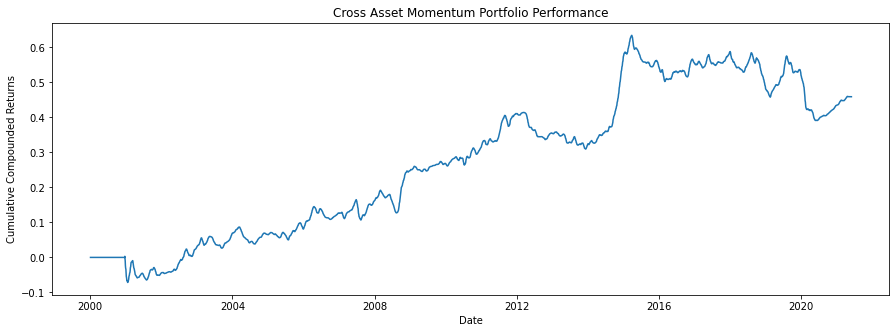

In [26]:
# Cumulative Compounded Returns for Cross Asset Portfolio
cum_rets = (1 + CAM.port_rets).cumprod(axis=0) - 1 

plt.figure(figsize=(15,5))
plt.title('Cross Asset Momentum Portfolio Performance')

plt.plot(prices.index, cum_rets)
plt.xlabel("Date")
plt.ylabel("Cumulative Compounded Returns")
plt.show()

# Signal Vector

In [27]:
CAM.signal

,DAX Index,Eurostoxx 50 Index,FTSE 100 Index,S&P 500 Index,Nasdaq 100 Index,Nikkei 225 Index,Topix Index,KOSPI 200 Index,Hang Seng Index,EURUSD,GBPUSD,SEKUSD,CADUSD,JPYUSD,AUDUSD,NZDUSD,USDKRW,Brent Crude,WTI Crude,Heating Oil,Natural Gas,Gold,Silver,Copper,Corn,Soybean,Eurodollar,UST 2Y,UST 5Y,UST 10Y,UST Long,Euro Schatz,Euro Bobl,Euro Bund,Gilt 10Y,JGB 10Y,AGB 3Y,AGB 10Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,1,1,1,1,1,1,1,1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
2021-06-01,1,1,1,1,1,-1,1,1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
2021-06-02,1,1,1,1,1,1,1,1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


# Visualization of Cross-Sectional Weights

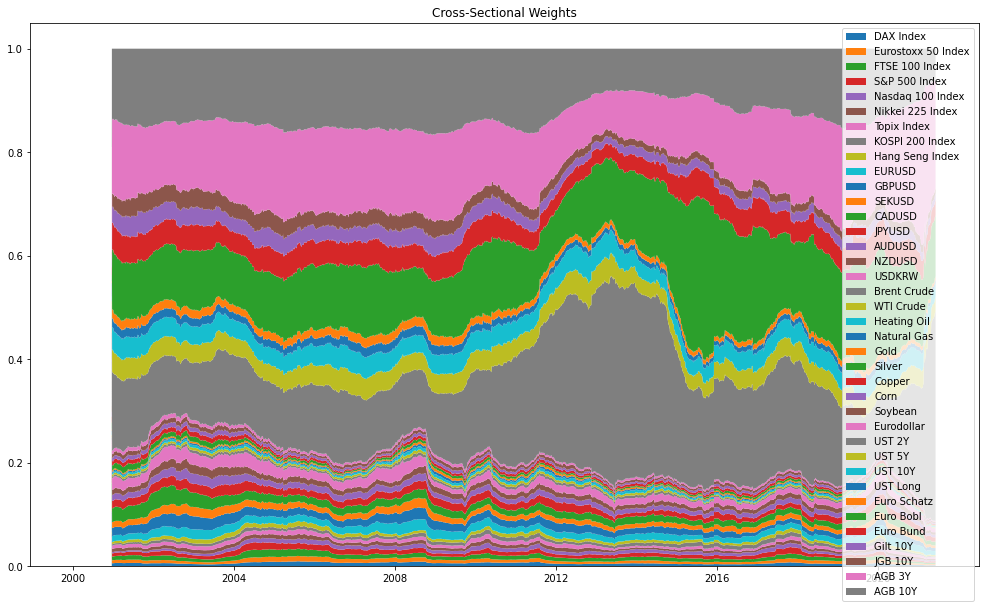

In [39]:
cs_rw = CAM.cs_risk_weight

plt.figure(figsize=(17,10))
plt.title('Cross-Sectional Weights')
plt.stackplot(prices.index, cs_rw.transpose(), labels=prices.columns)
plt.legend()
plt.show()

# Visualization of Time-Series Weights

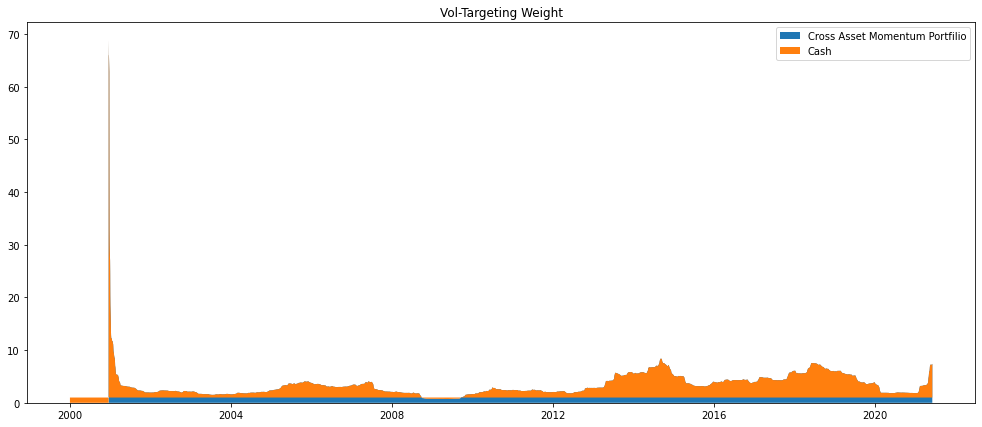

In [41]:
ts_rw = CAM.ts_risk_weight
ts_rw = pd.DataFrame([ts_rw, 1-ts_rw])

plt.figure(figsize=(17,7))
plt.title('Vol-Targeting Weight')
plt.stackplot(prices.index, ts_rw, labels = ['Cross Asset Momentum Portfilio', 'Cash'])
plt.legend()
plt.show()